In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('./data/aggregate_201019.csv')
target = 'reuse'
IDcol = 'project'
train.dropna()
train.pop('maven_release')
train.pop('release')

0        1.0.0
1          0.7
2       2.5.23
3       2.3.14
4       2.5.23
        ...   
425      2.4.8
426      2.6.1
427    1.3.7-3
428    1.4.3-1
429        1.1
Name: release, Length: 430, dtype: object

In [2]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    #print(alg)
    #print(alg.booster())
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    #print(feat_imp[::10])
    feat_imp.plot(kind='bar', title='Feature Importances')
    predictors = feat_imp.index.tolist()
    plt.ylabel('Feature Importance Score')
    feat_imp2 = feat_imp.to_frame()
    for predictor in predictors:
        if feat_imp2[0][predictor] <10:
            predictors.remove(predictor)
    return predictors

In [3]:
train.head()

,project,maven_reuse,class_count,synchronizedMethodsQty_sum,synchronizedMethodsQty_average,synchronizedMethodsQty_stdev,synchronizedMethodsQty_median,synchronizedMethodsQty_min,synchronizedMethodsQty_max,parenthesizedExpsQty_sum,...,innerClassesQty_stdev,innerClassesQty_median,innerClassesQty_min,innerClassesQty_max,comparisonsQty_sum,comparisonsQty_average,comparisonsQty_stdev,comparisonsQty_median,comparisonsQty_min,comparisonsQty_max
0,aalto-xml,23.0,158,514.0,3.253165,11.642190,0.0,0.0,114.0,1744.0,...,0.342153,0.0,0.0,2.0,2833.0,17.930380,54.521441,3.0,0.0,423.0
1,airline,49.0,135,0.0,0.000000,0.000000,0.0,0.0,0.0,13.0,...,1.694885,0.0,0.0,17.0,105.0,0.777778,2.636332,0.0,0.0,17.0
2,akka-actor,208.0,2965,1248.0,0.420911,1.178230,0.0,0.0,21.0,8753.0,...,2.569414,0.0,0.0,48.0,8629.0,2.910287,9.747351,0.0,0.0,224.0
3,akka-remote,31.0,1182,339.0,0.296070,0.866344,0.0,0.0,8.0,2455.0,...,1.926408,0.0,0.0,34.0,2337.0,2.041048,6.947673,0.0,0.0,88.0
4,akka-slf4j,135.0,2965,1248.0,0.420911,1.178230,0.0,0.0,21.0,8753.0,...,2.569414,0.0,0.0,48.0,8629.0,2.910287,9.747351,0.0,0.0,224.0


In [11]:
train.describe()

,maven_reuse,class_count,synchronizedMethodsQty_sum,synchronizedMethodsQty_average,synchronizedMethodsQty_stdev,synchronizedMethodsQty_median,synchronizedMethodsQty_min,synchronizedMethodsQty_max,parenthesizedExpsQty_sum,parenthesizedExpsQty_average,...,innerClassesQty_stdev,innerClassesQty_median,innerClassesQty_min,innerClassesQty_max,comparisonsQty_sum,comparisonsQty_average,comparisonsQty_stdev,comparisonsQty_median,comparisonsQty_min,comparisonsQty_max
count,407.00000,430.000000,294.000000,289.000000,294.000000,294.0,294.0,294.000000,294.000000,289.000000,...,294.000000,294.0,294.0,294.000000,294.000000,289.000000,294.000000,294.000000,294.0,294.000000
mean,295.55774,1245.130233,136.687075,0.112648,0.706466,0.0,0.0,12.574830,1058.411565,0.996712,...,1.153777,0.0,0.0,25.455782,2414.574830,1.937876,6.112285,0.190476,0.0,88.928571
std,772.66303,3113.423634,278.214929,0.249372,1.156667,0.0,0.0,18.293759,2280.810861,1.642401,...,1.265652,0.0,0.0,44.518467,6467.377667,2.780557,6.721082,0.923403,0.0,97.182624
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,19.00000,0.000000,1.000000,0.003841,0.048806,0.0,0.0,1.000000,33.750000,0.196481,...,0.414852,0.0,0.0,3.000000,86.000000,0.731985,2.338612,0.000000,0.0,18.250000
50%,50.00000,92.000000,15.000000,0.041667,0.376822,0.0,0.0,5.000000,171.000000,0.471264,...,0.813937,0.0,0.0,8.000000,494.500000,1.172913,4.628858,0.000000,0.0,46.000000
75%,243.00000,675.500000,95.000000,0.114379,0.860314,0.0,0.0,19.750000,766.750000,1.079710,...,1.562017,0.0,0.0,24.000000,1737.750000,2.324324,7.430448,0.000000,0.0,140.750000
max,7388.00000,14013.000000,1248.000000,3.253165,11.642190,0.0,0.0,114.000000,20263.000000,13.600000,...,12.969737,0.0,0.0,358.000000,88339.000000,36.071429,58.773966,8.500000,0.0,599.000000


In [10]:
np.nanpercentile(train['maven_reuse'], [20, 40, 60, 80])

array([ 13. ,  36. ,  77.6, 369. ])

In [12]:
np.nanpercentile(train['maven_reuse'], [10, 20, 30, 40, 50, 60, 70, 80, 90])

array([  2. ,  13. ,  24. ,  36. ,  50. ,  77.6, 156.4, 369. , 605.4])

In [14]:
def f(x):
    arr = [13, 36, 77.6, 369]
    for i in range(len(arr)):
        if x['maven_reuse']<arr[i]:
            return int(i) 
train['reuse_5'] = train.apply(f, axis=1)

<AxesSubplot:>

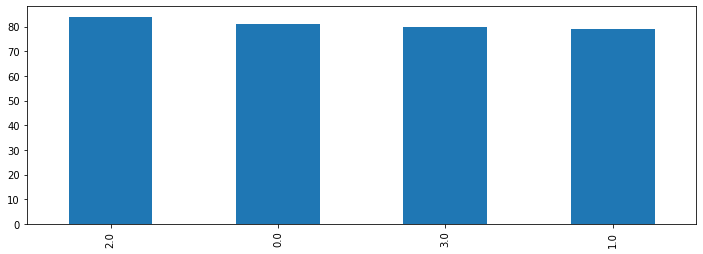

In [15]:
train.reuse_5.value_counts().plot(kind='bar')

In [17]:
def f(x):
    arr = [2,13,24,36,50,77.6,156.4,369,605.4]
    for i in range(len(arr)):
        if x['maven_reuse']<arr[i]:
            return int(i) 
train['reuse_10'] = train.apply(f, axis=1)

<AxesSubplot:>

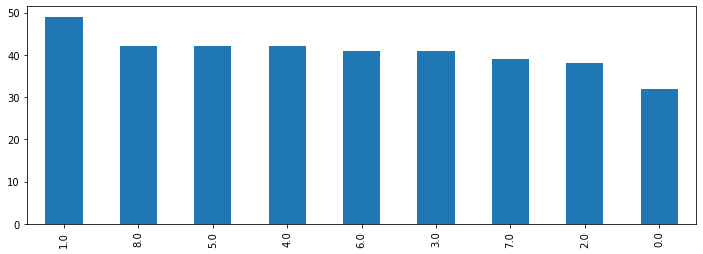

In [18]:
train.reuse_10.value_counts().plot(kind='bar')

In [20]:
def f(x):
    if x['maven_reuse'] < 19: return 0
    elif x['maven_reuse'] < 243 and x['maven_reuse']>=19: return 1
    else: return 2

train['reuse'] = train.apply(f, axis=1)

In [21]:
train.corr()

,maven_reuse,class_count,synchronizedMethodsQty_sum,synchronizedMethodsQty_average,synchronizedMethodsQty_stdev,synchronizedMethodsQty_median,synchronizedMethodsQty_min,synchronizedMethodsQty_max,parenthesizedExpsQty_sum,parenthesizedExpsQty_average,...,innerClassesQty_max,comparisonsQty_sum,comparisonsQty_average,comparisonsQty_stdev,comparisonsQty_median,comparisonsQty_min,comparisonsQty_max,reuse_5,reuse_10,reuse
maven_reuse,1.000000,0.111404,0.052810,0.016368,0.064051,NaN,NaN,0.046512,0.024507,-0.031631,...,0.131425,0.004681,-0.054316,0.016302,-0.064350,NaN,0.132807,0.786660,0.817139,0.468843
class_count,0.111404,1.000000,0.808823,-0.074762,-0.036378,NaN,NaN,0.275050,0.826668,-0.126334,...,0.616117,0.718909,-0.109057,-0.063417,-0.076673,NaN,0.429130,0.189387,0.368624,0.324168
synchronizedMethodsQty_sum,0.052810,0.808823,1.000000,0.230427,0.232231,NaN,NaN,0.472101,0.821889,0.043147,...,0.531970,0.561890,-0.005076,0.083938,-0.073346,NaN,0.491959,0.120455,0.303441,0.246956
synchronizedMethodsQty_average,0.016368,-0.074762,0.230427,1.000000,0.885572,NaN,NaN,0.604732,0.064993,0.519291,...,-0.044582,-0.006902,0.454563,0.561079,0.195459,NaN,0.302530,-0.053092,-0.103899,0.010862
synchronizedMethodsQty_stdev,0.064051,-0.036378,0.232231,0.885572,1.000000,NaN,NaN,0.848340,0.059461,0.389688,...,-0.020652,0.014249,0.356678,0.504659,0.073043,NaN,0.346587,-0.101335,-0.120440,0.027047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
comparisonsQty_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comparisonsQty_max,0.132807,0.429130,0.491959,0.302530,0.346587,NaN,NaN,0.459801,0.527843,0.255984,...,0.356345,0.422186,0.309401,0.642747,-0.031129,NaN,1.000000,0.051800,0.149725,0.168742
reuse_5,0.786660,0.189387,0.120455,-0.053092,-0.101335,NaN,NaN,-0.078414,0.120788,-0.058322,...,0.103671,0.068808,0.004037,-0.028043,0.039265,NaN,0.051800,1.000000,0.975132,0.800795
reuse_10,0.817139,0.368624,0.303441,-0.103899,-0.120440,NaN,NaN,-0.020238,0.283230,-0.121771,...,0.272961,0.191870,-0.079149,-0.065514,-0.055982,NaN,0.149725,0.975132,1.000000,0.884603
